In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
# import signal_generation as sg
# import channel_model as ch
import hpcom
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
# from sklearn.externals import joblib

import xgboost as xgb

from datetime import datetime
from importlib import reload
reload(hpcom)

from composer import *
from estimator import *
from collector import *

In [2]:
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/data/data_collected_3.pkl'
path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_wo_noise_2.pkl'
path_to_data_w_noise = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_w_noise_2.pkl'
# path_to_data = '/users/1/190243539/files/data_collected_extended_wo_noise_2.pkl'
# path_to_data_w_noise = '/users/1/190243539/files/data_collected_extended_w_noise_2.pkl'

In [ ]:

df = pd.read_pickle(path_to_data)
df_noise = pd.read_pickle(path_to_data_w_noise)


n_neighbours = 5
n_gauss = 0
train_runs = [k for k in range(18)]

# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# train_runs = [0, 1, 2, 3, 4, 5, 6]
# train_runs = [0, 1, 2]

test_runs = [k for k in range(18, 20)]
# test_runs = [0, 1]
# test_runs = [8, 9]

p_ave_dbm = 6
z_km = 80 * 20
n_channels = 1
sigma = 1.5

print(df.size, df_noise.size)
df = pd.concat([df, df_noise], ignore_index=True, sort=False)
print(df.size)
df_tree = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss)
# df_tree = get_data_with_m_neighbor(df_noise, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours,
#                                    r=0.1, n_gauss=n_gauss, scale_type='constellation')
df_tree_for_test = get_data_with_m_neighbor(df_noise, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours,
                                            r=0.1, n_gauss=n_gauss, scale_type='constellation')

# df_tree = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, train_runs, n_neighbours, r=0.1, n_gauss=n_gauss, sigma=sigma)
# df_tree_for_test = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=1, sigma=sigma)

print(df_tree.head())
df = pd.DataFrame([])
df_noise = pd.DataFrame([])
del df, df_noise

In [ ]:
print("P_ave [dBm] = ", p_ave_dbm)
p_ave = (10 ** (p_ave_dbm / 10)) / 1000
mod_type = hpcom.modulation.get_modulation_type_from_order(16)
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave / 2)
constellation = hpcom.modulation.get_constellation('16qam')

In [ ]:
labels_to_drop = ['point_orig_abs', 'point_orig_angle',
                  'point_orig_real', 'point_orig_imag',
                  'point_label',
                  'diff_real', 'diff_imag',
                  'diff_sq_real', 'diff_sq_imag',
                  'diff_circle_real', 'diff_circle_imag',
                  'diff_p3_real', 'diff_p3_imag']

# for get_data_with_m_neighbor
labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_real' for m in range(n_gauss)] + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

# for get_data_gauss_parallel
# labels_to_drop = labels_to_drop + [f'diff_gauss_real'] + [f'diff_gauss_imag']

# chose what to predict
# label_predict = ['diff_circle_real', 'diff_circle_imag']
label_predict = ['diff_real', 'diff_imag']
m = 5
# label_predict = [f'diff_gauss_{m}_real', f'diff_gauss_{m}_imag']
# label_predict = [f'diff_gauss_real', f'diff_gauss_imag']
# label_predict = ['diff_p3_real', 'diff_p3_imag']
# label_predict = ['point_label']

In [ ]:
X_for_test = df_tree_for_test.drop(labels=labels_to_drop, axis=1)
points_init_for_test = df_tree_for_test['point_orig_abs'].values * np.exp(1.0j * df_tree_for_test['point_orig_angle'])
labels_for_test = df_tree_for_test['point_label']

In [ ]:
y = df_tree[[label_predict[0], label_predict[1]]].values
X = df_tree.drop(labels=labels_to_drop, axis=1)

In [ ]:
split_ratio = 0.01
random_state = 42

# X_train, X_test, y_real_train, y_real_test = train_test_split(X, y_real, test_size=split_ratio, random_state=random_state)
# _, _, y_imag_train, y_imag_test = train_test_split(X, y_imag, test_size=split_ratio, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=random_state)
po_abs_train, po_abs_test, po_angle_train, po_angle_test = train_test_split(df_tree['point_orig_abs'].values, df_tree['point_orig_angle'].values, test_size=split_ratio, random_state=random_state)

## Random Forest

In [ ]:
n_estimators = 100
n_jobs = 60  # number of cores to use
random_state_for_tree = 73
start_time = datetime.now()
# model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state_for_tree, n_jobs=n_jobs, verbose=1)
model.warm_start = True  # start from previous state of the forest (add new trees)
model.n_estimators += n_estimators
model.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
result = predict_and_eval((model, ), X_for_test, points_init_for_test,
                          p_ave_dbm, scale_type='constellation', name='RF new data test')

points_orig_for_test = result['points_orig']
points_predict_for_test = result['points_predict']

_ = predict_and_eval((model, ), X_test, po_abs_test * np.exp(1.0j * po_angle_test), 
                     p_ave_dbm, scale_type='constellation', name='RF same data test')

result = predict_and_eval((model, ), X_train, po_abs_train * np.exp(1.0j * po_angle_train),
                          p_ave_dbm, scale_type='constellation', name='RF same data train')

points_orig_train = result['points_orig']
points_predict_train = result['points_predict']

In [ ]:
plot_result(p_ave_dbm, 
            points_predict_for_test, points_orig_for_test, 
            points_predict_train, points_orig_train)

#### Test with other p_ave

In [ ]:
# There is no 0dbm! Do not run if dataframe doesn't have it
X_test_0dbm, points_init_test_0dbm = get_data_for_test(path_to_data_w_noise,
                                                       p_ave_dbm=0,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

In [7]:
X_test_2dbm, points_init_test_2dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=2,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_3dbm, points_init_test_3dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=3,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_4dbm, points_init_test_4dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=4,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_5dbm, points_init_test_5dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=5,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)


X_test_6dbm, points_init_test_6dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=6,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_7dbm, points_init_test_7dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=7,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_8dbm, points_init_test_8dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=8,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

In [ ]:
_ = predict_and_eval((model, ), 
                     X_test_5dbm, points_init_test_5dbm, 
                     p_ave_dbm=5, scale_type='constellation', name='RF 5 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_4dbm, points_init_test_4dbm, 
                     p_ave_dbm=4, scale_type='constellation', name='RF 4 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_6dbm, points_init_test_6dbm, 
                     p_ave_dbm=6, scale_type='constellation', name='RF 6 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_7dbm, points_init_test_7dbm, 
                     p_ave_dbm=7, scale_type='constellation', name='RF 7 dbm test')

### Thin out the forest

In [ ]:
# model has N trees

evm_for_each_tree = []
k_stop = 10  # I like that it sounds like k-pop
k = 0
for tree in model:
    ber, evm = predict_and_eval_short((tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
    evm_for_each_tree.append(evm)
    if k == k_stop:
        break
    
evm_for_each_tree = np.array(evm_for_each_tree)


In [ ]:
pos_min = np.argmax(evm_for_each_tree)
print(pos_min, evm_for_each_tree[pos_min])

In [ ]:
y_pred = model[pos_min].predict(X_for_test.values)
print(y_pred, np.shape(y_pred))

In [ ]:
y_pred = np.zeros((131072, 2))
for tree in model:
    y_pred = y_pred + tree.predict(X_for_test.values)

In [ ]:
points_orig = X_for_test['point_x_abs'].values * np.exp(1.0j * X_for_test['point_x_angle'].values)
points_predict = np.real(points_orig) + y_pred[:,0] + 1.0j * (np.imag(points_orig) + y_pred[:,1])

In [ ]:
p_found_orig_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
p_found_pred_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_predict * scale_constellation, constellation)

ber_orig = hpcom.metrics.get_ber_by_points(points_init_for_test * scale_constellation, p_found_orig_for_test, '16qam')
ber_predict = hpcom.metrics.get_ber_by_points(points_init_for_test * scale_constellation, p_found_pred_for_test, '16qam')

q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
q_orig_db = 20 * np.log10(q_orig)
q_pred_db = 20 * np.log10(q_pred)
evm_orig = hpcom.metrics.get_evm_rms_new(points_init_for_test, points_orig)
evm_pred = hpcom.metrics.get_evm_rms_new(points_init_for_test, points_predict)
ber_evm_orig = hpcom.metrics.get_ber_from_evm(points_init_for_test, points_orig, 16)
ber_evm_pred = hpcom.metrics.get_ber_from_evm(points_init_for_test, points_predict, 16)

name = 'test'
name = name.center(len(name) + 10, '-')
print_out = [name, f'Number of points {np.shape(points_init_for_test)}',
             f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
             f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
             f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
             f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']

for line in print_out:
    print(line)

## Tree  

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
random_state_for_tree = 73
max_depth = 5

start_time = datetime.now()

regression_tree = DecisionTreeRegressor(random_state=random_state_for_tree, 
                                         max_depth=max_depth)
regression_tree.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
result = predict_and_eval((regression_tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
points_orig_for_test = result['points_orig']
points_predict_for_test = result['points_predict']

_ = predict_and_eval((regression_tree, ), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='same data test')

result = predict_and_eval((regression_tree, ), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='same data train')
points_orig_train = result['points_orig']
points_predict_train = result['points_predict']

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

In [ ]:
np.random.randint(1, 1000)

In [ ]:
## We want to select that trees which gives us the best results

n_trees_total = 10
forest = []
n_trees_selected = 0

limit_max_depth = 1000

verbose = 1

start_time = datetime.now()
while n_trees_selected < n_trees_total:
    # here we train each tree and than select if it is alright for us or not
    
    max_depth = np.random.randint(1, limit_max_depth)
#     random_state_for_tree = np.random.randint(1, 10000)
    
    start_time = datetime.now()
    
#     regression_tree = DecisionTreeRegressor(random_state=random_state_for_tree, 
#                                             max_depth=max_depth)
    regression_tree = DecisionTreeRegressor(max_depth=max_depth)
    regression_tree = regression_tree.fit(X_train, y_train)
    
    if verbose >= 1:
        calculation_time = (datetime.now() - start_time).total_seconds()
        print("\n tree took: ", calculation_time * 1000, "ms \n")
        
    
    
    ber_delta = predict_and_eval_short((regression_tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
    print(ber_delta)
    
    if ber_delta > 0:
#         print(ber_delta)
        forest.append([regression_tree, ber_delta])
        n_trees_selected = n_trees_selected + 1
        
    if n_trees_selected % 1 == 0:
        print(n_trees_selected, '/', n_trees_total)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")
    

## Gradient Boosting

### SKLearn

In [ ]:
y_train

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
random_state_for_tree = 73

n_estimators = 100
learning_rate = 0.1

start_time = datetime.now()

# gb_tree_real = GradientBoostingRegressor(random_state=random_state_for_tree,
#                                          n_estimators=n_estimators,
#                                          learning_rate=learning_rate,
#                                          verbose=1)
gb_tree_real.warm_start = True
gb_tree_real.n_estimators += n_estimators
gb_tree_real.fit(X_train, y_train[:, 0])  # y_train[:, 0] correesponds to real part

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
start_time = datetime.now()

# gb_tree_imag = GradientBoostingRegressor(random_state=random_state_for_tree,
#                                          n_estimators=n_estimators,
#                                          learning_rate=learning_rate,
#                                          verbose=1)
gb_tree_imag.warm_start = True
gb_tree_imag.n_estimators += n_estimators
gb_tree_imag.fit(X_train, y_train[:, 1])  # y_train[:, 0] correesponds to real part

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
result = predict_and_eval((gb_tree_real, gb_tree_imag), X_for_test, points_init_for_test, p_ave_dbm, name='GBR new data test')
points_orig_for_test = result['points_orig']
points_predict_for_test = result['points_predict']

_ = predict_and_eval((gb_tree_real, gb_tree_imag), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='GBR same data test')

result = predict_and_eval((gb_tree_real, gb_tree_imag), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='GBR same data train')
points_orig_train = result['points_orig']
points_predict_train = result['points_predict']

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

### XGBoost

#### Scikit-learn interface

In [ ]:
import xgboost as xgb

In [ ]:
# Scikit-Learn interface

random_state_for_tree = 0
learning_rate = 0.4
reg_lambda = 0.0  # 1.0 - L2 regularization term on weights. Increasing this value will make model more conservative.
reg_alpha = 0.9  # 0.0 - L1 regularization term on weights. Increasing this value will make model more conservative.
n_estimators = 20000
max_depth = 200

start_time = datetime.now()
# Use "gpu_hist" for training the model.
xgb_reg = xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           reg_lambda=reg_lambda,
                           reg_alpha=reg_alpha,
                           seed=random_state_for_tree)
# Fit the model using predictor X and response y.
xgb_reg.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

# Save model into JSON format.
# reg.save_model("regressor.json")

In [ ]:
result = predict_and_eval((xgb_reg,), X_for_test, points_init_for_test, p_ave_dbm, name='XGBR new data test')
points_orig_for_test = result['points_orig']
points_predict_for_test = result['points_predict']

_ = predict_and_eval((xgb_reg,), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='XGBR same data test')

result = predict_and_eval((xgb_reg,), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='XGBR same data train')
points_orig_train = result['points_orig']
points_predict_train = result['points_predict']

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

#### Cross test same model for different power levels

In [ ]:
_ = predict_and_eval((xgb_reg, ), 
                     X_test_2dbm, points_init_test_2dbm, 
                     p_ave_dbm=2, scale_type='constellation', name='RF 2 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_3dbm, points_init_test_3dbm, 
                     p_ave_dbm=3, scale_type='constellation', name='RF 3 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_4dbm, points_init_test_4dbm, 
                     p_ave_dbm=4, scale_type='constellation', name='RF 4 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_5dbm, points_init_test_5dbm, 
                     p_ave_dbm=5, scale_type='constellation', name='RF 5 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_6dbm, points_init_test_6dbm, 
                     p_ave_dbm=6, scale_type='constellation', name='RF 6 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_7dbm, points_init_test_7dbm, 
                     p_ave_dbm=7, scale_type='constellation', name='RF 7 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_8dbm, points_init_test_8dbm, 
                     p_ave_dbm=8, scale_type='constellation', name='RF 8 dbm test')

In [ ]:
xgb.plot_importance(xgb_reg)

#### Data collection for different power levels

In [3]:
paths_to_data = [path_to_data, path_to_data_w_noise]

n_neighbours = 5

train_runs = [k for k in range(18)]

# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# train_runs = [0, 1, 2, 3, 4, 5, 6]
# train_runs = [0, 1, 2]

test_runs = [k for k in range(18, 20)]
# test_runs = [0, 1]
# test_runs = [8, 9]

p_list=[1, 2, 3, 4, 5, 6, 7, 8]
# p_ave_dbm = 6
z_km = 80 * 20

df_result_total = pd.DataFrame()

for p_ave_dbm_current in p_list:
    df_current = train_xgboost(paths_to_data, p_ave_dbm_current, z_km, train_runs, test_runs, p_list=p_list, data_type='wnwon_1')
    df_result_total = pd.concat([df_result_total, df_current], ignore_index=True)

Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.004039764404296875, 2118) / -0.0018596649169921875)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 4.4282275948315115e-11 / 0.0018617838414258963)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 8.460747820005974 / -0.6387516039465737)
EVM [%] (orig / pred / delta) (15.91897452062733 / 6.942399534907841 / 8.97657498571949
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0069675445556640625, 3653) / -0.00229644775390625)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 3.086359768622977e-07 / 0.00392549394131944)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 7.814931452227282 / -0.4821004132576876)
EVM [%] (orig / pred / delta) (17.469641417901013 / 9.071590030327348 / 8.3980513875

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.01458740234375, 7648) / -0.003078460693359375)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 0.00026055627139263824 / 0.010121112299615584)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 6.773577050267431 / -0.3589378381569599)
EVM [%] (orig / pred / delta) (20.31192640559671 / 13.18585471108287 / 7.126071694513842
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.029630661010742188, 15535) / -0.0044040679931640625)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.006835588755545236 / 0.018338829981440874)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 5.511983400022782 / -0.3158447920772387)
EVM [%] (orig / pred / delta) (24.427346402685444 / 18.942111556812534 / 5.485234845872908
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.05549430847167969, 29095) / -0.00429534912109375)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.03550040148841984 / 0.0172318640885889)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.04848722616678 / -0.2130343545520086)
EVM [%] (orig / pred / delta) (30.350668461575932 / 26.758857189027946 / 3.5918112725479845
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.09126853942871094, 47851) / -0.0043849945068359375)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.07848273770849566 / 0.0120429239874362)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 2.4964982475163118 / -0.17554813484982867)
EVM [%] (orig / pred / delta) (38.17475953368538 / 35.619575443558084 / 2.555184090127299
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.13508987426757812, 70826) / -0.002803802490234375)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.1231405577806111 / 0.011381974250952123)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 0.8487434709267582 / -0.10181296460576428)
EVM [%] (orig / pred / delta) (48.72701516703037 / 45.75577832961967 / 2.971236837410701
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.0029926300048828125, 1569) / -0.000812530517578125)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 2.035838933350391e-14 / 0.001861783885687814)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 8.782192332400454 / -0.31730709155209347)
EVM [%] (orig / pred / delta) (15.91897452062733 / 5.946065769875539 / 9.972908750751792
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0056304931640625, 2952) / -0.0009593963623046875)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 1.9064790373126654e-08 / 0.00392578351250593)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.077825265918909 / -0.2192065995660606)
EVM [%] (orig / pred / delta) (17.469641417901013 / 8.208240165519378 / 9.2614012523

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.012664794921875, 6640) / -0.001155853271484375)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 0.00013370275689329525 / 0.010247965814114926)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 6.990751789182794 / -0.14176309924159636)
EVM [%] (orig / pred / delta) (20.31192640559671 / 12.525856569973524 / 7.786069835623188
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.027116775512695312, 14217) / -0.0018901824951171875)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.006278092185741093 / 0.018896326551245013)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 5.6884634594718895 / -0.1393647326281311)
EVM [%] (orig / pred / delta) (24.427346402685444 / 18.693606851149422 / 5.733739551536021
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.05377006530761719, 28191) / -0.00257110595703125)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.03633087874101176 / 0.016401386835996977)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.133002706182428 / -0.12851887453636035)
EVM [%] (orig / pred / delta) (30.350668461575932 / 26.937987591718475 / 3.412680869857454
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.08968353271484375, 47020) / -0.00279998779296875)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.07981361353335727 / 0.010712048162574594)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 2.5596211020365733 / -0.11242528032956711)
EVM [%] (orig / pred / delta) (38.17475953368538 / 35.89758411690835 / 2.277175416777033
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.1339588165283203, 70233) / -0.0016727447509765625)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.12371048036120458 / 0.010812051670358647)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 0.8897820426023975 / -0.06077439293012499)
EVM [%] (orig / pred / delta) (48.72701516703037 / 45.89978273436572 / 2.8272324326646503
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.0022029876708984375, 1155) / -2.288818359375e-05)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 3.2472487743545985e-17 / 0.0018617838857081397)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 9.089370304076963 / -0.01012911987558418)
EVM [%] (orig / pred / delta) (15.91897452062733 / 5.373961791647189 / 10.54501272898014
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0045528411865234375, 2387) / 0.000118255615234375)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 1.5839138485164602e-09 / 0.0039258009933824545)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.326353675683606 / 0.029321810198636555)
EVM [%] (orig / pred / delta) (17.469641417901013 / 7.611909475844109 / 9.857731

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.010995864868164062, 5765) / 0.0005130767822265625)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 6.084514984434176e-05 / 0.01032082342116388)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 7.198646451264449 / 0.0661315628400585)
EVM [%] (orig / pred / delta) (20.31192640559671 / 11.857637100779952 / 8.45428930481676
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.024600982666015625, 12898) / 0.0006256103515625)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.004645892052325704 / 0.020528526684660403)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 5.875368929351238 / 0.0475407372512171)
EVM [%] (orig / pred / delta) (24.427346402685444 / 17.882357753811288 / 6.544988648874156
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.05087471008300781, 26673) / 0.000324249267578125)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.03294563353296798 / 0.019786632044040763)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.277953845990086 / 0.016432265271297375)
EVM [%] (orig / pred / delta) (30.350668461575932 / 26.201527015232845 / 4.149141446343085
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.08699417114257812, 45610) / -0.000110626220703125)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.07667825782082512 / 0.013847403875106745)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 2.6675814178929462 / -0.004464964473194222)
EVM [%] (orig / pred / delta) (38.17475953368538 / 35.244088094066555 / 2.930671439618826
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.13242149353027344, 69427) / -0.0001354217529296875)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.12155063575642282 / 0.012971896275140407)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 0.9456325003185307 / -0.004923935213991704)
EVM [%] (orig / pred / delta) (48.72701516703037 / 45.35652802028673 / 3.3704871467436446
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.0019397735595703125, 1017) / 0.000240325927734375)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 2.4810578456400402e-18 / 0.0018617838857081699)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 9.21132211391876 / 0.11182268996621225)
EVM [%] (orig / pred / delta) (15.91897452062733 / 5.187272262697514 / 10.731702257929816
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0039577484130859375, 2075) / 0.000713348388671875)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 1.7268100374257116e-10 / 0.003925802404615299)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.483427232936585 / 0.186395367451615)
EVM [%] (orig / pred / delta) (17.469641417901013 / 7.17607102335194 / 10.2935703945

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.010049819946289062, 5269) / 0.0014591217041015625)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 2.1836181338111833e-05 / 0.01035983238967011)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 7.326526214087706 / 0.19401132566331558)
EVM [%] (orig / pred / delta) (20.31192640559671 / 11.12507106562139 / 9.186855339975322
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.022661209106445312, 11881) / 0.0025653839111328125)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.0028413185673372395 / 0.02233310016964887)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 6.027761577419746 / 0.19993338531972515)
EVM [%] (orig / pred / delta) (24.427346402685444 / 16.747274051181073 / 7.680072351504369
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.04832267761230469, 25335) / 0.00287628173828125)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.026934932010117405 / 0.025797333566891335)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.409165888950681 / 0.14764430823189212)
EVM [%] (orig / pred / delta) (30.350668461575932 / 24.842214047711558 / 5.5084544138643725
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.08429336547851562, 44194) / 0.002590179443359375)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.06981760300686209 / 0.020708058689069775)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 2.777159296070449 / 0.10511291370430875)
EVM [%] (orig / pred / delta) (38.17475953368538 / 33.82949409998396 / 4.345265433701417
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.13071632385253906, 68533) / 0.0015697479248046875)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.11670153072530669 / 0.017821001306256537)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 1.0076833917514472 / 0.05712695621892472)
EVM [%] (orig / pred / delta) (48.72701516703037 / 44.16057606478348 / 4.566439102246894
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.00179290771484375, 940) / 0.0003871917724609375)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 4.526648005767098e-15 / 0.0018617838857036457)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 9.285232069112139 / 0.18573264515959131)
EVM [%] (orig / pred / delta) (15.91897452062733 / 5.796461169224468 / 10.122513351402862
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0036296844482421875, 1903) / 0.001041412353515625)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 7.135215506833104e-10 / 0.003925801863774752)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.57793381774687 / 0.2809019522618996)
EVM [%] (orig / pred / delta) (17.469641417901013 / 7.4462367014916 / 10.02340471640941

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.009130477905273438, 4787) / 0.0023784637451171875)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 1.439911410056315e-05 / 0.01036726945690766)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 7.459284752578371 / 0.3267698641539809)
EVM [%] (orig / pred / delta) (20.31192640559671 / 10.862830913391944 / 9.449095492204767
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.020681381225585938, 10843) / 0.0045452117919921875)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.0018842646114959733 / 0.023290154125490136)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 6.1920717450045615 / 0.3642435529045409)
EVM [%] (orig / pred / delta) (24.427346402685444 / 15.94091111135161 / 8.486435291333832
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.045135498046875, 23664) / 0.0060634613037109375)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.02118889781142932 / 0.03154336776557942)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.57811396579518 / 0.3165923850763912)
EVM [%] (orig / pred / delta) (30.350668461575932 / 23.449557459770435 / 6.901111001805493
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.08091163635253906, 42421) / 0.0059719085693359375)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.06185794008670864 / 0.02866772160922322)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 2.916141254126814 / 0.24409487176067346)
EVM [%] (orig / pred / delta) (38.17475953368538 / 32.20608456459452 / 5.9686749690908645
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.12786483764648438, 67038) / 0.004421234130859375)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.10985170264326544 / 0.024670829388297788)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 1.1117120344162463 / 0.16115559888372388)
EVM [%] (orig / pred / delta) (48.72701516703037 / 42.52298274422215 / 6.2040324228082255
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.0020618438720703125, 1081) / 0.000118255615234375)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 6.270956554927803e-09 / 0.0018617776147516172)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 9.153223495326895 / 0.053724071374347204)
EVM [%] (orig / pred / delta) (15.91897452062733 / 7.9252672086918885 / 7.993707311935442
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0038356781005859375, 2011) / 0.000835418701171875)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 4.050445005990406e-07 / 0.003925397532795704)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.517861306727688 / 0.22082944124271897)
EVM [%] (orig / pred / delta) (17.469641417901013 / 9.170883835192493 / 8.29875758

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.008983612060546875, 4710) / 0.00252532958984375)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 6.480714384617643e-05 / 0.010316861427162045)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 7.481369963986779 / 0.3488550755623887)
EVM [%] (orig / pred / delta) (20.31192640559671 / 11.907418993464178 / 8.404507412132533
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.019544601440429688, 10247) / 0.0056819915771484375)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.002063632571253411 / 0.023110786165732696)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 6.291022844493277 / 0.4631946523932564)
EVM [%] (orig / pred / delta) (24.427346402685444 / 16.109931041037807 / 8.317415361647637
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.04269599914550781, 22385) / 0.008502960205078125)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.01837167580056541 / 0.03436058977644333)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.711692651951193 / 0.4501710712324041)
EVM [%] (orig / pred / delta) (30.350668461575932 / 22.71654804317317 / 7.6341204184027625
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.0769195556640625, 40328) / 0.0099639892578125)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.054823439172074245 / 0.035702222523857616)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 3.083007352407687 / 0.4109609700415464)
EVM [%] (orig / pred / delta) (38.17475953368538 / 30.776507161707006 / 7.3982523719783755
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.12440109252929688, 65222) / 0.007884979248046875)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.10283258882824052 / 0.031689943203322704)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 1.2385720753875442 / 0.28801563985502177)
EVM [%] (orig / pred / delta) (48.72701516703037 / 40.901361000068206 / 7.825654166962165
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.0035228729248046875, 1847) / -0.0013427734375)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 8.364565394756453e-05 / 0.0017781382317606077)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 8.610125706315962 / -0.4893737176365853)
EVM [%] (orig / pred / delta) (15.91897452062733 / 12.115132886917626 / 3.8038416337097036
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0054912567138671875, 2879) / -0.000820159912109375)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 0.00020940368442781197 / 0.0037163988928684906)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.107797184398045 / -0.18923468108692454)
EVM [%] (orig / pred / delta) (17.469641417901013 / 12.958768426939809 / 4.5108729

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.010677337646484375, 5598) / 0.00083160400390625)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 0.001007583889285599 / 0.009374084681722622)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 7.240801897376857 / 0.10828700895246612)
EVM [%] (orig / pred / delta) (20.31192640559671 / 14.899872519098075 / 5.412053886498636
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.021120071411132812, 11073) / 0.0041065216064453125)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.005005237030087407 / 0.0201691817068987)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 6.154824671820177 / 0.32699647972015633)
EVM [%] (orig / pred / delta) (24.427346402685444 / 18.073868096294003 / 6.353478306391438
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.04219245910644531, 22121) / 0.009006500244140625)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.020457833639351643 / 0.0322744319376571)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.7397668303642835 / 0.47824524964549475)
EVM [%] (orig / pred / delta) (30.350668461575932 / 23.263177979955536 / 7.087490481620396
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.07432937622070312, 38970) / 0.012554168701171875)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.051550026625981425 / 0.038975635069950436)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 3.1930595336104908 / 0.5210131512443503)
EVM [%] (orig / pred / delta) (38.17475953368538 / 30.10949207027943 / 8.06526746340595
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.12047576904296875, 63164) / 0.011810302734375)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.0961316073422925 / 0.03839092468927073)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 1.3830847820362293 / 0.43252834650370686)
EVM [%] (orig / pred / delta) (48.72701516703037 / 39.40006013957908 / 9.326955027451294
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.010868072509765625, 5698) / -0.008687973022460938)
ber from EVM_rms (orig / pred / delta) (0.0018617838857081723 / 0.006807264373454298 / -0.004945480487746126)
q-factor [dB] (orig / pred / delta) (9.099499423952548 / 7.215454316663453 / -1.8840451072890945)
EVM [%] (orig / pred / delta) (15.91897452062733 / 18.92976820434395 / -3.01079368371662
Data shape: (9,)
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.0136566162109375, 7160) / -0.008985519409179688)
ber from EVM_rms (orig / pred / delta) (0.003925802577296303 / 0.007985107134372098 / -0.004059304557075796)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 6.876093246670862 / -1.420938618814107)
EVM [%] (orig / pred / delta) (17.469641417901013 / 19.420954526577727 / -1.951313108676

C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011508941650390625, 6034) / (0.01947021484375, 10208) / -0.007961273193359375)
ber from EVM_rms (orig / pred / delta) (0.010381668571008222 / 0.011238507493947381 / -0.0008568389229391595)
q-factor [dB] (orig / pred / delta) (7.1325148884243905 / 6.297626412040508 / -0.8348884763838829)
EVM [%] (orig / pred / delta) (20.31192640559671 / 20.604219693749155 / -0.2922932881524426
Data shape: (9,)
P_ave [dBm] =  5
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.025226593017578125, 13226) / (0.0299835205078125, 15720) / -0.004756927490234375)
ber from EVM_rms (orig / pred / delta) (0.025174418736986108 / 0.01801585201155462 / 0.007158566725431487)
q-factor [dB] (orig / pred / delta) (5.827828192100021 / 5.487941497246606 / -0.3398866948534147)
EVM [%] (orig / pred / delta) (24.427346402685444 / 22.620884165374207 / 1.806462237311235
Data shape: (9,)
P_ave [dBm] =  6
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.0487823486328125, 25576) / 0.0024166107177734375)
ber from EVM_rms (orig / pred / delta) (0.05273226557700874 / 0.03255793337326632 / 0.020174332203742422)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.385277805383653 / 0.12375622466486469)
EVM [%] (orig / pred / delta) (30.350668461575932 / 26.116036537805158 / 4.23463192377077
Data shape: (9,)
P_ave [dBm] =  7
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.086883544921875, 45552) / (0.0766754150390625, 40200) / 0.0102081298828125)
ber from EVM_rms (orig / pred / delta) (0.09052566169593186 / 0.056561167932579676 / 0.033964493763352185)
q-factor [dB] (orig / pred / delta) (2.6720463823661404 / 3.0933180300185894 / 0.42127164765244896)
EVM [%] (orig / pred / delta) (38.17475953368538 / 31.12985607734158 / 7.044903456343804
Data shape: (9,)
P_ave [dBm] =  8
Scale data to correspond to initial constellation


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


-----RF 8 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.13228607177734375, 69356) / (0.11871910095214844, 62243) / 0.013566970825195312)
ber from EVM_rms (orig / pred / delta) (0.13452253203156322 / 0.09308983527601339 / 0.041432696755549836)
q-factor [dB] (orig / pred / delta) (0.9505564355325224 / 1.448044060523333 / 0.49748762499081045)
EVM [%] (orig / pred / delta) (48.72701516703037 / 38.732001768101476 / 9.995013398928897
Data shape: (9,)


C:\Users\190243539\anaconda3\envs\tfgpu_env\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [4]:
df_result_total

,z_km,p_ave_dbm_train,p_ave_dbm_test,ber_orig,ber_pred,q_db_orig,q_db_pred,evm_orig,evm_pred
0,1600,1,1,"(0.001434326171875, 752)","(0.003063201904296875, 1606)",9.488618,8.757985,0.153555,0.061612
1,1600,1,2,"(0.0021800994873046875, 1143)","(0.004039764404296875, 2118)",9.099499,8.460748,0.159190,0.069424
2,1600,1,3,"(0.0046710968017578125, 2449)","(0.0069675445556640625, 3653)",8.297032,7.814931,0.174696,0.090716
3,1600,1,4,"(0.011508941650390625, 6034)","(0.01458740234375, 7648)",7.132515,6.773577,0.203119,0.131859
4,1600,1,5,"(0.025226593017578125, 13226)","(0.029630661010742188, 15535)",5.827828,5.511983,0.244273,0.189421
...,...,...,...,...,...,...,...,...,...
59,1600,8,4,"(0.011508941650390625, 6034)","(0.01947021484375, 10208)",7.132515,6.297626,0.203119,0.206042
60,1600,8,5,"(0.025226593017578125, 13226)","(0.0299835205078125, 15720)",5.827828,5.487941,0.244273,0.226209
61,1600,8,6,"(0.05119895935058594, 26843)","(0.0487823486328125, 25576)",4.261522,4.385278,0.303507,0.261160
62,1600,8,7,"(0.086883544921875, 45552)","(0.0766754150390625, 40200)",2.672046,3.093318,0.381748,0.311299


#### XGBoost interface

In [ ]:
# form dtrain matrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)

param = {'max_depth': 100, 
         'objective': 'reg:squarederror',
         'tree_method': 'gpu_hist',  # GPU cersion of hist algorithm
         'lambda': 1.0,  # 1.0 - L2 regularization term on weights. Increasing this value will make model more conservative
         'alpha': 0.0,  # 0.0 - L1 regularization term on weights. Increasing this value will make model more conservative.
        }

In [23]:
def get_data_for_test(path_to_data, p_ave_dbm, z_km,
                      test_runs,
                      n_channels=1,
                      n_neighbours=4,
                      n_gauss=0):
    
    df = pd.read_pickle(path_to_data)

    sigma = 1.5


    df_tree_for_test = get_data_with_m_neighbor(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, 
                                                r=0.1, n_gauss=n_gauss, scale_type='constellation')
    # df_tree_for_test = get_data_gauss_parallel(df, z_km, p_ave_dbm, n_channels, test_runs, n_neighbours, r=0.1, n_gauss=1, sigma=sigma)

    df = pd.DataFrame([])
    del df
    
    labels_to_drop = ['point_orig_abs', 'point_orig_angle',
                  'point_orig_real', 'point_orig_imag',
                  'point_label',
                  'diff_real', 'diff_imag',
                  'diff_sq_real', 'diff_sq_imag',
                  'diff_circle_real', 'diff_circle_imag',
                  'diff_p3_real', 'diff_p3_imag']

    # for get_data_with_m_neighbor
    labels_to_drop = labels_to_drop + [f'diff_gauss_{m}_real' for m in range(n_gauss)] + [f'diff_gauss_{m}_imag' for m in range(n_gauss)]

    # for get_data_gauss_parallel
    # labels_to_drop = labels_to_drop + [f'diff_gauss_real'] + [f'diff_gauss_imag']

    
    X_for_test = df_tree_for_test.drop(labels=labels_to_drop, axis=1)
    points_init_for_test = df_tree_for_test['point_orig_abs'].values * np.exp(1.0j * df_tree_for_test['point_orig_angle'])
    labels_for_test = df_tree_for_test['point_label']
    
    return X_for_test, points_init_for_test



In [244]:
X_test_2dbm, points_init_test_2dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=2,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_3dbm, points_init_test_3dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=3,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_4dbm, points_init_test_4dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=4,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_5dbm, points_init_test_5dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=5,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)


X_test_6dbm, points_init_test_6dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=6,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_7dbm, points_init_test_7dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=7,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

X_test_8dbm, points_init_test_8dbm = get_data_for_test(path_to_data_w_noise, 
                                                       p_ave_dbm=8,
                                                       z_km = z_km,
                                                       test_runs = test_runs,
                                                       n_channels=1,
                                                       n_neighbours=n_neighbours,
                                                       n_gauss=0)

Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_2_x_imag', 'minus_m_1_x_im

run number 19
(65536, 11)
Scale data to correspond to initial constellation
['point_orig_abs', 'point_orig_angle', 'point_orig_real', 'point_orig_imag', 'point_label', 'diff_real', 'diff_imag', 'diff_sq_real', 'diff_sq_imag', 'diff_circle_real', 'diff_circle_imag', 'diff_p3_real', 'diff_p3_imag', 'minus_m_5_x_abs', 'minus_m_4_x_abs', 'minus_m_3_x_abs', 'minus_m_2_x_abs', 'minus_m_1_x_abs', 'point_x_abs', 'plus_m_1_x_abs', 'plus_m_2_x_abs', 'plus_m_3_x_abs', 'plus_m_4_x_abs', 'plus_m_5_x_abs', 'minus_m_5_x_angle', 'minus_m_4_x_angle', 'minus_m_3_x_angle', 'minus_m_2_x_angle', 'minus_m_1_x_angle', 'point_x_angle', 'plus_m_1_x_angle', 'plus_m_2_x_angle', 'plus_m_3_x_angle', 'plus_m_4_x_angle', 'plus_m_5_x_angle', 'minus_m_5_x_real', 'minus_m_4_x_real', 'minus_m_3_x_real', 'minus_m_2_x_real', 'minus_m_1_x_real', 'point_x_real', 'plus_m_1_x_real', 'plus_m_2_x_real', 'plus_m_3_x_real', 'plus_m_4_x_real', 'plus_m_5_x_real', 'minus_m_5_x_imag', 'minus_m_4_x_imag', 'minus_m_3_x_imag', 'minus_m_

In [90]:
_ = predict_and_eval((model, ), 
                     X_test_5dbm, points_init_test_5dbm, 
                     p_ave_dbm=5, scale_type='constellation', name='RF 5 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_4dbm, points_init_test_4dbm, 
                     p_ave_dbm=4, scale_type='constellation', name='RF 4 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_6dbm, points_init_test_6dbm, 
                     p_ave_dbm=6, scale_type='constellation', name='RF 6 dbm test')

_ = predict_and_eval((model, ), 
                     X_test_7dbm, points_init_test_7dbm, 
                     p_ave_dbm=7, scale_type='constellation', name='RF 7 dbm test')

P_ave [dBm] =  5
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.2s finished


-----RF 5 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.026178359985351562, 13725) / (0.025068283081054688, 13143) / 0.001110076904296875)
ber from EVM_rms (orig / pred / delta) (0.026236106958939243 / 0.004353198025032555 / 0.021882908933906688)
q-factor [dB] (orig / pred / delta) (5.756880940123481 / 5.839788562869883 / 0.08290762274640162)
EVM [%] (orig / pred / delta) (24.678612856337605 / 17.719666374549952 / 6.958946481787653
P_ave [dBm] =  4
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.0s finished


-----RF 4 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.011217117309570312, 5881) / (0.0001010894775390625, 53) / 0.01111602783203125)
ber from EVM_rms (orig / pred / delta) (0.010278922950172133 / 1.9807122623010305e-24 / 0.010278922950172133)
q-factor [dB] (orig / pred / delta) (7.169868526851037 / 11.402164377946447 / 4.23229585109541)
EVM [%] (orig / pred / delta) (20.276073991253067 / 4.425930154201199 / 15.850143837051869
P_ave [dBm] =  6
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    1.0s finished


-----RF 6 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.050571441650390625, 26514) / (0.04932403564453125, 25860) / 0.001247406005859375)
ber from EVM_rms (orig / pred / delta) (0.05200937059976101 / 0.027023960428913398 / 0.024985410170847613)
q-factor [dB] (orig / pred / delta) (4.2933701927694745 / 4.357273816119125 / 0.06390362334965083)
EVM [%] (orig / pred / delta) (30.203241513047274 / 24.862959575540387 / 5.340281937506888
P_ave [dBm] =  7
Scale data to correspond to initial constellation


[Parallel(n_jobs=60)]: Using backend ThreadingBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=60)]: Done 200 out of 200 | elapsed:    0.9s finished


-----RF 7 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.09035682678222656, 47373) / (0.09062767028808594, 47515) / -0.000270843505859375)
ber from EVM_rms (orig / pred / delta) (0.09368914562674342 / 0.07127435339554387 / 0.02241479223119955)
q-factor [dB] (orig / pred / delta) (2.5327628687682506 / 2.521977276941136 / -0.010785591827114693)
EVM [%] (orig / pred / delta) (38.86300858403585 / 34.12835968635245 / 4.734648897683408


### Thin out the forest

In [ ]:
# model has N trees

evm_for_each_tree = []
k_stop = 10  # I like that it sounds like k-pop
k = 0
for tree in model:
    ber, evm = predict_and_eval_short((tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
    evm_for_each_tree.append(evm)
    if k == k_stop:
        break
    
evm_for_each_tree = np.array(evm_for_each_tree)


In [ ]:
pos_min = np.argmax(evm_for_each_tree)
print(pos_min, evm_for_each_tree[pos_min])

In [ ]:
y_pred = model[pos_min].predict(X_for_test.values)
print(y_pred, np.shape(y_pred))

In [ ]:
y_pred = np.zeros((131072, 2))
for tree in model:
    y_pred = y_pred + tree.predict(X_for_test.values)

In [ ]:
points_orig = X_for_test['point_x_abs'].values * np.exp(1.0j * X_for_test['point_x_angle'].values)
points_predict = np.real(points_orig) + y_pred[:,0] + 1.0j * (np.imag(points_orig) + y_pred[:,1])

In [ ]:
p_found_orig_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
p_found_pred_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_predict * scale_constellation, constellation)

ber_orig = hpcom.metrics.get_ber_by_points(points_init_for_test * scale_constellation, p_found_orig_for_test, '16qam')
ber_predict = hpcom.metrics.get_ber_by_points(points_init_for_test * scale_constellation, p_found_pred_for_test, '16qam')

q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
q_orig_db = 20 * np.log10(q_orig)
q_pred_db = 20 * np.log10(q_pred)
evm_orig = hpcom.metrics.get_evm_rms_new(points_init_for_test, points_orig)
evm_pred = hpcom.metrics.get_evm_rms_new(points_init_for_test, points_predict)
ber_evm_orig = hpcom.metrics.get_ber_from_evm(points_init_for_test, points_orig, 16)
ber_evm_pred = hpcom.metrics.get_ber_from_evm(points_init_for_test, points_predict, 16)

name = 'test'
name = name.center(len(name) + 10, '-')
print_out = [name, f'Number of points {np.shape(points_init_for_test)}',
             f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
             f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
             f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
             f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']

for line in print_out:
    print(line)

## Tree  

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
random_state_for_tree = 73
max_depth = 5

start_time = datetime.now()

regression_tree = DecisionTreeRegressor(random_state=random_state_for_tree, 
                                         max_depth=max_depth)
regression_tree.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
points_orig_for_test, points_predict_for_test = predict_and_eval((regression_tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
_ = predict_and_eval((regression_tree, ), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='same data test')
points_orig_train, points_predict_train = predict_and_eval((regression_tree, ), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='same data train')

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

In [ ]:
def predict_and_eval_short(model, X_test, points_init, p_ave_dbm, name='test'):

    # p_ave_dbm_expl = 6
    p_ave_dbm_expl = p_ave_dbm
    print("P_ave [dBm] = ", p_ave_dbm_expl)
    p_ave_expl = (10 ** (p_ave_dbm_expl / 10)) / 1000
    mod_type = hpcom.modulation.get_modulation_type_from_order(16)
    scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
    constellation = hpcom.modulation.get_constellation('16qam')

    points_orig = X_test['point_x_abs'].values * np.exp(1.0j * X_test['point_x_angle'].values)
    # points_predict = predict(model_real, model_imag, X_test, inverse_function=inverse_p3, parameters=[scale_constellation])
    if len(model) == 2:
        points_predict = predict(model[0], model[1], X_test, inverse_function=None, parameters=None)
    else:
        points_predict = predict_single(model[0], X_test, inverse_function=None, parameters=None)



    p_found_orig_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_orig * scale_constellation, constellation)
    p_found_pred_for_test = hpcom.modulation.get_nearest_constellation_points_new(points_predict * scale_constellation, constellation)

    ber_orig = hpcom.metrics.get_ber_by_points(points_init * scale_constellation, p_found_orig_for_test, '16qam')
    ber_predict = hpcom.metrics.get_ber_by_points(points_init * scale_constellation, p_found_pred_for_test, '16qam')

    q_orig = np.sqrt(2) * sp.special.erfcinv(2 * ber_orig[0])
    q_pred = np.sqrt(2) * sp.special.erfcinv(2 * ber_predict[0])
    q_orig_db = 20 * np.log10(q_orig)
    q_pred_db = 20 * np.log10(q_pred)
    evm_orig = hpcom.metrics.get_evm_rms_new(points_init, points_orig)
    evm_pred = hpcom.metrics.get_evm_rms_new(points_init, points_predict)
    ber_evm_orig = hpcom.metrics.get_ber_from_evm(points_init, points_orig, 16)
    ber_evm_pred = hpcom.metrics.get_ber_from_evm(points_init, points_predict, 16)
    
    name = name.center(len(name) + 10, '-')
    print_out = [name, f'Number of points {np.shape(points_init)}',
                 f'ber (orig / pred / delta) ({ber_orig} / {ber_predict} / {ber_orig[0] - ber_predict[0]})',
                 f'ber from EVM_rms (orig / pred / delta) ({ber_evm_orig} / {ber_evm_pred} / {ber_evm_orig - ber_evm_pred})',
                 f'q-factor [dB] (orig / pred / delta) ({q_orig_db} / {q_pred_db} / {q_pred_db - q_orig_db})',
                 f'EVM [%] (orig / pred / delta) ({evm_orig * 100.} / {evm_pred * 100.} / {(evm_orig - evm_pred) * 100}']
    
#     print(print_out[2])
#     print(print_out[4])
#     print(print_out[5])

    return ber_orig[0] - ber_predict[0], evm_orig - evm_pred

In [ ]:
np.random.randint(1, 1000)

In [ ]:
## We want to select that trees which gives us the best results

n_trees_total = 10
forest = []
n_trees_selected = 0

limit_max_depth = 1000

verbose = 1

start_time = datetime.now()
while n_trees_selected < n_trees_total:
    # here we train each tree and than select if it is alright for us or not
    
    max_depth = np.random.randint(1, limit_max_depth)
#     random_state_for_tree = np.random.randint(1, 10000)
    
    start_time = datetime.now()
    
#     regression_tree = DecisionTreeRegressor(random_state=random_state_for_tree, 
#                                             max_depth=max_depth)
    regression_tree = DecisionTreeRegressor(max_depth=max_depth)
    regression_tree = regression_tree.fit(X_train, y_train)
    
    if verbose >= 1:
        calculation_time = (datetime.now() - start_time).total_seconds()
        print("\n tree took: ", calculation_time * 1000, "ms \n")
        
    
    
    ber_delta = predict_and_eval_short((regression_tree, ), X_for_test, points_init_for_test, p_ave_dbm, name='new data test')
    print(ber_delta)
    
    if ber_delta > 0:
#         print(ber_delta)
        forest.append([regression_tree, ber_delta])
        n_trees_selected = n_trees_selected + 1
        
    if n_trees_selected % 1 == 0:
        print(n_trees_selected, '/', n_trees_total)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")
    

## Gradient Boosting

### SKLearn

In [ ]:
y_train

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
random_state_for_tree = 73

n_estimators = 100
learning_rate = 0.1

start_time = datetime.now()

# gb_tree_real = GradientBoostingRegressor(random_state=random_state_for_tree,
#                                          n_estimators=n_estimators,
#                                          learning_rate=learning_rate,
#                                          verbose=1)
gb_tree_real.warm_start = True
gb_tree_real.n_estimators += n_estimators
gb_tree_real.fit(X_train, y_train[:, 0])  # y_train[:, 0] correesponds to real part

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
start_time = datetime.now()

# gb_tree_imag = GradientBoostingRegressor(random_state=random_state_for_tree,
#                                          n_estimators=n_estimators,
#                                          learning_rate=learning_rate,
#                                          verbose=1)
gb_tree_imag.warm_start = True
gb_tree_imag.n_estimators += n_estimators
gb_tree_imag.fit(X_train, y_train[:, 1])  # y_train[:, 0] correesponds to real part

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

In [ ]:
points_orig_for_test, points_predict_for_test = predict_and_eval((gb_tree_real, gb_tree_imag), X_for_test, points_init_for_test, p_ave_dbm, name='GBR new data test')
_ = predict_and_eval((gb_tree_real, gb_tree_imag), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='GBR same data test')
points_orig_train, points_predict_train = predict_and_eval((gb_tree_real, gb_tree_imag), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='GBR same data train')

In [ ]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

### XGBoost

#### Scikit-learn interface

In [91]:
import xgboost as xgb

In [249]:
# Scikit-Learn interface

random_state_for_tree = 0
learning_rate = 0.4
reg_lambda = 0.0  # 1.0 - L2 regularization term on weights. Increasing this value will make model more conservative.
reg_alpha = 0.9  # 0.0 - L1 regularization term on weights. Increasing this value will make model more conservative.
n_estimators = 20000
max_depth = 200

start_time = datetime.now()
# Use "gpu_hist" for training the model.
xgb_reg = xgb.XGBRegressor(tree_method="gpu_hist",
                           n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           reg_lambda=reg_lambda,
                           reg_alpha=reg_alpha,
                           seed=random_state_for_tree)
# Fit the model using predictor X and response y.
xgb_reg.fit(X_train, y_train)

calculation_time = (datetime.now() - start_time).total_seconds()
print("model took: \n", 
      calculation_time * 1000, "ms \n",
      calculation_time, "s \n",
      calculation_time / 60., "min \n")

# Save model into JSON format.
# reg.save_model("regressor.json")

model took: 
 335857.33800000005 ms 
 335.857338 s 
 5.5976223 min 



In [247]:
points_orig_for_test, points_predict_for_test = predict_and_eval((xgb_reg,), X_for_test, points_init_for_test, p_ave_dbm, name='XGBR new data test')
_ = predict_and_eval((xgb_reg,), X_test, po_abs_test * np.exp(1.0j * po_angle_test), p_ave_dbm, name='XGBR same data test')
points_orig_train, points_predict_train = predict_and_eval((xgb_reg,), X_train, po_abs_train * np.exp(1.0j * po_angle_train), p_ave_dbm, name='XGBR same data train')

P_ave [dBm] =  6
Scale data to correspond to initial constellation
-----XGBR new data test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.05119895935058594, 26843) / (0.040676116943359375, 21326) / 0.010522842407226562)
ber from EVM_rms (orig / pred / delta) (0.05273226557700926 / 0.02191034829214531 / 0.03082191728486395)
q-factor [dB] (orig / pred / delta) (4.261521580718789 / 4.825416598905163 / 0.5638950181863747)
EVM [%] (orig / pred / delta) (30.350668461576035 / 23.631137622002303 / 6.719530839573731
P_ave [dBm] =  6
Scale data to correspond to initial constellation
-----XGBR same data test-----
Number of points (11797,)
ber (orig / pred / delta) ((0.04592269220988387, 2167) / (0.03492413325421717, 1648) / 0.010998558955666697)
ber from EVM_rms (orig / pred / delta) (0.04795761517410231 / 0.01657538388110482 / 0.03138223129299749)
q-factor [dB] (orig / pred / delta) (4.53582533005587 / 5.167445291971395 / 0.6316199619155256)
EVM [%] (orig / pred / delta) (29.37387

Scale data to correspond to initial constellation


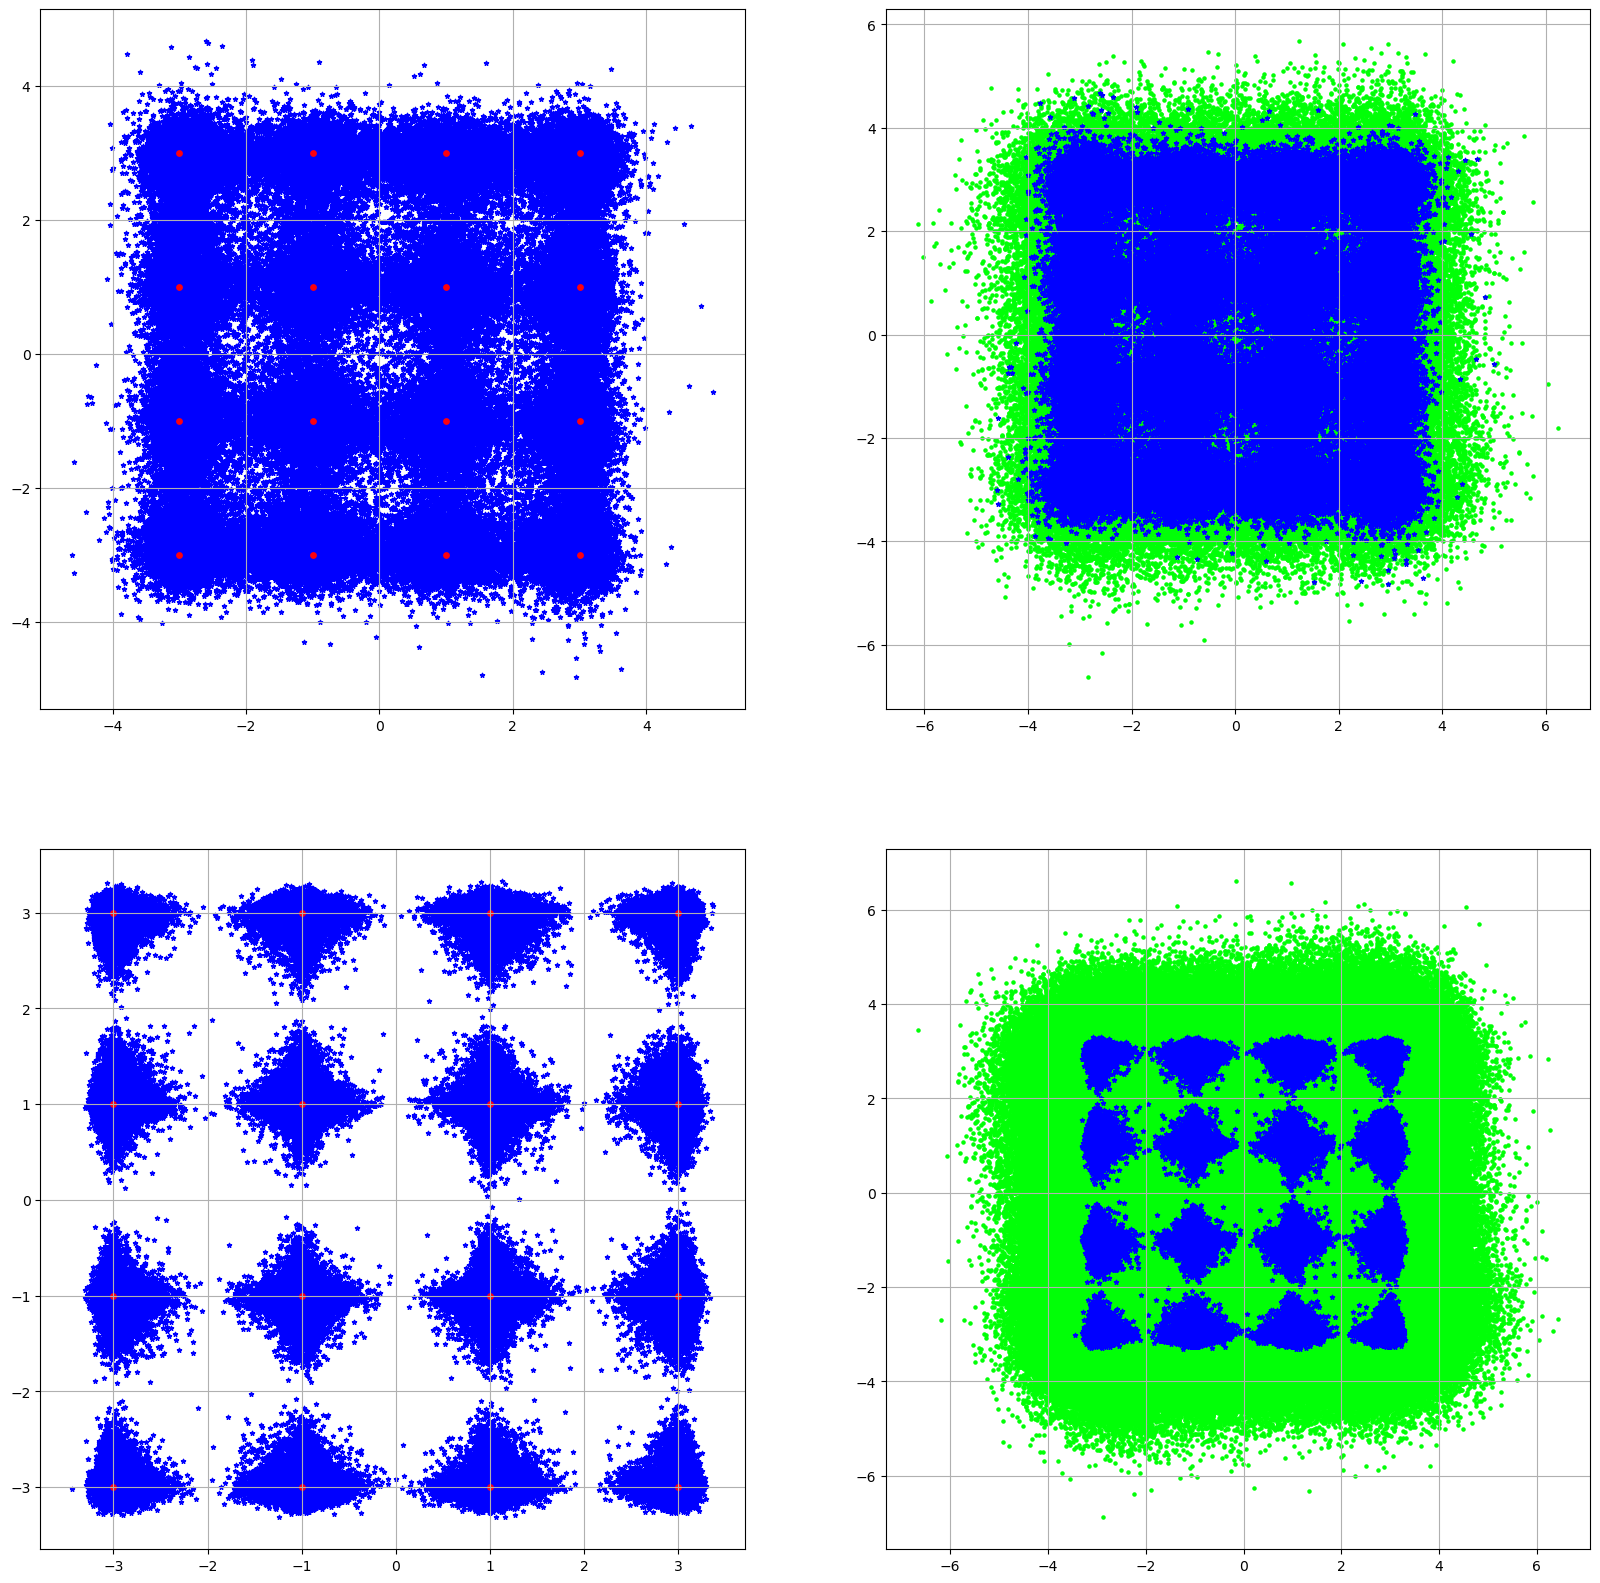

In [248]:
plot_result(p_ave_dbm, points_predict_for_test, points_orig_for_test, points_predict_train, points_orig_train)

#### Cross test same model for different power levels

In [245]:
_ = predict_and_eval((xgb_reg, ), 
                     X_test_2dbm, points_init_test_2dbm, 
                     p_ave_dbm=2, scale_type='constellation', name='RF 2 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_3dbm, points_init_test_3dbm, 
                     p_ave_dbm=3, scale_type='constellation', name='RF 3 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_4dbm, points_init_test_4dbm, 
                     p_ave_dbm=4, scale_type='constellation', name='RF 4 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_5dbm, points_init_test_5dbm, 
                     p_ave_dbm=5, scale_type='constellation', name='RF 5 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_6dbm, points_init_test_6dbm, 
                     p_ave_dbm=6, scale_type='constellation', name='RF 6 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_7dbm, points_init_test_7dbm, 
                     p_ave_dbm=7, scale_type='constellation', name='RF 7 dbm test')

_ = predict_and_eval((xgb_reg, ), 
                     X_test_8dbm, points_init_test_8dbm, 
                     p_ave_dbm=8, scale_type='constellation', name='RF 8 dbm test')

P_ave [dBm] =  2
Scale data to correspond to initial constellation
-----RF 2 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0021800994873046875, 1143) / (0.002017974853515625, 1058) / 0.0001621246337890625)
ber from EVM_rms (orig / pred / delta) (0.0018617838857082657 / 2.9922921682768465e-06 / 0.001858791593539989)
q-factor [dB] (orig / pred / delta) (9.099499423952546 / 9.173778609349437 / 0.07427918539689138)
EVM [%] (orig / pred / delta) (15.91897452062742 / 10.014334255238209 / 5.904640265389212
P_ave [dBm] =  3
Scale data to correspond to initial constellation
-----RF 3 dbm test-----
Number of points (131072,)
ber (orig / pred / delta) ((0.0046710968017578125, 2449) / (0.003570556640625, 1872) / 0.0011005401611328125)
ber from EVM_rms (orig / pred / delta) (0.0039258025772962585 / 1.8943771084673134e-05 / 0.003906858806211585)
q-factor [dB] (orig / pred / delta) (8.29703186548497 / 8.595662329079936 / 0.29863046359496614)
EVM [%] (orig / pred / delta) (17.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

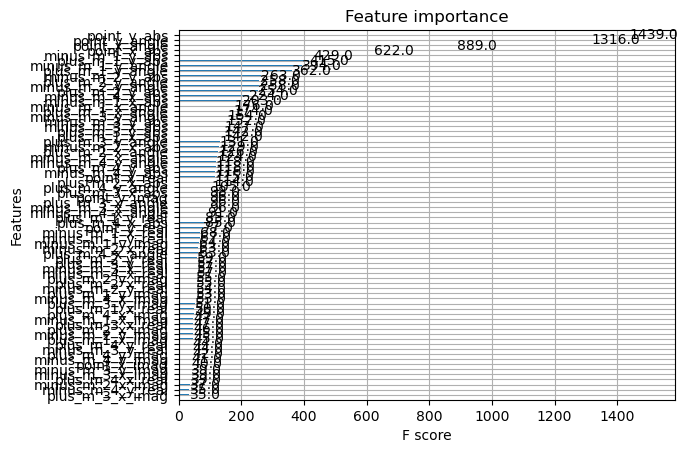

In [96]:
xgb.plot_importance(xgb_reg)

#### XGBoost interface

In [ ]:
# form dtrain matrix for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)

param = {'max_depth': 100, 
         'objective': 'reg:squarederror',
         'tree_method': 'gpu_hist',  # GPU cersion of hist algorithm
         'lambda': 1.0,  # 1.0 - L2 regularization term on weights. Increasing this value will make model more conservative
         'alpha': 0.0,  # 0.0 - L1 regularization term on weights. Increasing this value will make model more conservative.
        }

## K-means

In [ ]:
from sklearn.cluster import KMeans


In [ ]:
# path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/error_statistics/data/data_collected_3.pkl'
path_to_data = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_wo_noise_1.pkl'
path_to_data_w_noise = 'C:/Users/190243539/PycharmProjects/nn_essential/benchmark/data/data_collected_extended_w_noise_1.pkl'

df = pd.read_pickle(path_to_data)
print(df.columns.values)
print(df['p_ave_dbm'])
# df_noise = pd.read_pickle(path_to_data_w_noise)

# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# train_runs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
train_runs = [0, 1, 2]
test_runs = [3, 4]

p_ave_dbm = 1
z_km = 80 * 20
n_channels = 1

df_tree = get_data_wo_neighbor(df, z_km, p_ave_dbm, n_channels, train_runs)
df_tree_for_test = get_data_wo_neighbor(df, z_km, p_ave_dbm, n_channels, test_runs)
# df_tree_for_test = get_data_wo_neighbor(df_noise, z_km, p_ave_dbm, n_channels, test_runs)


print(df_tree.head())
df = pd.DataFrame([])
df_noise = pd.DataFrame([])
del df, df_noise

In [ ]:
df_tree

In [ ]:
# X = df_tree[['point_orig_real', 'point_orig_imag']].values
X = df_tree[['point_received_real', 'point_received_imag']].values
np.shape(X)


In [ ]:
# Instantiate the k-means model with the desired number of clusters
kmeans = KMeans(n_clusters=16)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster assignments for each point
labels = kmeans.labels_

# Get the coordinates of the cluster centers
cluster_centers = kmeans.cluster_centers_

In [ ]:
X_test = df_tree_for_test[['point_received_real', 'point_received_imag']].values

In [ ]:
predictions = kmeans.predict(X_test)

In [ ]:
p_pred_temp = kmeans.cluster_centers_[predictions]

In [ ]:
predictions

In [ ]:
# p_init = df_tree[['point_orig_real', 'point_orig_imag']].values
p_init = df_tree_for_test[['point_orig_real', 'point_orig_imag']].values
p_init = p_init[:, 0] + 1j * p_init[:, 1]
# p_prop = X[:, 0] + 1j * X[:, 1]
p_prop = X_test[:, 0] + 1j * X_test[:, 1]
p_predict = p_pred_temp[:, 0] + 1j * p_pred_temp[:, 1]

In [ ]:
p_ave_expl = (10 ** (p_ave_dbm / 10)) / 1000
mod_type = hpcom.modulation.get_modulation_type_from_order(16)
scale_constellation = hpcom.modulation.get_scale_coef_constellation(mod_type) / np.sqrt(p_ave_expl / 2)
constellation = hpcom.modulation.get_constellation('16qam')

p_found = hpcom.modulation.get_nearest_constellation_points_new(p_prop, constellation)
p_found_pred = hpcom.modulation.get_nearest_constellation_points_new(p_predict, constellation)

ber_orig = hpcom.metrics.get_ber_by_points(p_init, p_found, '16qam')
ber_predict = hpcom.metrics.get_ber_by_points(p_init, p_found_pred, '16qam')

print(ber_orig, ber_predict)

In [ ]:

#Visualizing the cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')

## Test some features

In [ ]:
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Generate a random dataset
X, y = make_regression(n_samples=1000, n_features=4, noise=0.1)

# Split the data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert the data into the format required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 1.0
}

# Train the XGBoost model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# Use the trained model to make predictions on the test data
y_pred = bst.predict(dtest)

# Evaluate the performance of the model
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

import numpy as np

def custom_objective(preds, dtrain):
    labels = dtrain.get_label()
    mse_loss = np.mean((preds - labels)**2)
    mae_loss = np.mean(np.abs(preds - labels))
    return 'custom_loss', mse_loss + mae_loss, False


params['objective'] = custom_objective
bst = xgb.train(params, dtrain, num_rounds)

y_pred = bst.predict(dtest)
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
